In [1]:
%matplotlib notebook

import pyvisgraph as vg
import numpy as np
import matplotlib.pyplot as plt
import QRDB as qrdb
import EKF_SLAM as ekf
import time
import os
from math import *

In [2]:
import pyzbar.pyzbar as pyzbar
import cv2
import yaml


In [3]:
from picar import front_wheels, back_wheels
from picar.SunFounder_PCA9685 import Servo
import picar
from time import sleep
picar.setup()
length_ofedge=0.16
bw = back_wheels.Back_Wheels()
fw = front_wheels.Front_Wheels()
pan_servo = Servo.Servo(1)
tilt_servo = Servo.Servo(2)
picar.setup()
# - left
# + right
# to be measured directly on the picar
offset = 9
# pan_servo.offset = 10
# tilt_servo.offset = 0
initial_angle_fw=90+offset
bw.speed = 0
fw.turn(initial_angle_fw)
pan_servo.write(90)
tilt_servo.write(100)

# motor_speed = 70
# 70i*3=127cm, i= 1.27/210 m/s
# 70i=1.27/3=0.42333333333333334m/s
# 40i~100i=0.2419047619~0.60476190476 m/s
L=0.14
true_speed_unit=0.15/35
MAX_SPEED=100*true_speed_unit
MIN_SPEED=70*true_speed_unit
MIN_RADIAN=1.0/180*pi
MAX_TRUN_LEFT=(initial_angle_fw-120)*pi/180
MAX_TRUN_RIGHT=(initial_angle_fw-60)*pi/180

def ctl_straight(speed,dt,st):
    """constant speed straight control driver connected to PiCar-V""" 
    bw.stop()
    fw.turn(initial_angle_fw)
    sleep(st)
    bw.speed=speed
    bw.backward()
    sleep(dt)
    bw.stop()
    sleep(st)
def ctl_constant_turning(speed,angle,dt,st):
    """constant speed constant turning control driver connected to PiCar-V""" 
    bw.stop()
    fw.turn(angle)
    sleep(st)
    bw.speed=speed
    bw.backward()
    sleep(dt)
    bw.stop()
    sleep(st)

DEBUG "back_wheels.py": Set debug off
DEBUG "TB6612.py": Set debug off
DEBUG "TB6612.py": Set debug off
DEBUG "PCA9685.py": Set debug off
DEBUG "front_wheels.py": Set debug off
DEBUG "front_wheels.py": Set wheel debug off
DEBUG "Servo.py": Set debug off


In [4]:
def safe_arange(start, stop, step):
    return step * np.arange(start / step, stop / step)
def hline(xa,xb,y,stepsize,ox,oy):
    for i in safe_arange(xa, xb, stepsize):
        ox.append(i)
        oy.append(y)
def vline(ya,yb,x,stepsize,ox,oy):
    for i in safe_arange(ya, yb, stepsize):
        ox.append(x)
        oy.append(i)
def sqaure(x_min,x_max,y_min,y_max,stepsize,ox,oy):
    hline(x_min,x_max,y_min,stepsize,ox,oy)
    hline(x_min,x_max,y_max,stepsize,ox,oy)
    vline(round(y_min+stepsize,3),y_max,x_min,stepsize,ox,oy)
    vline(y_min,round(y_max+stepsize,3),x_max,stepsize,ox,oy)

def visibility_planner(g,waypoints):
    overall_path=np.array([]).reshape(-1,2)
    for i in range(len(waypoints)):
        if i != waypoints.shape[0]-1:
            way1=waypoints[[i],:]
            way2=waypoints[[i+1],:]
            path=g.shortest_path(vg.Point(way1[0][0],way1[0][1]), vg.Point(way2[0][0],way2[0][1]))
            path_coords=np.array([[a.x,a.y] for a in path])
            path_coords=np.concatenate((way1,path_coords,way2),axis=0)
            overall_path=np.concatenate((overall_path,path_coords),axis=0)
    return overall_path

def plot_path(ax,overall_edges,color):
    for a,b in overall_edges:
        vo=ax.plot(a, b, color, linewidth=2)
    return vo

In [5]:

ox = []
oy = []

sqaure(-1.5,1.5,-1.5,1.3,0.01,ox,oy)
sqaure(-0.45,0.45,-0.28,0.28,0.01,ox,oy)

waypoints=np.array([[0.75,-0.75],[0,0.65],[-1,0]])

polys = [[vg.Point(-0.45, -0.28), vg.Point(-0.45, 0.28), vg.Point(0.45, 0.28),vg.Point(0.45, -0.28)]]
g = vg.VisGraph()
g.build(polys)
overall_path=visibility_planner(g,waypoints)

<IPython.core.display.Javascript object>


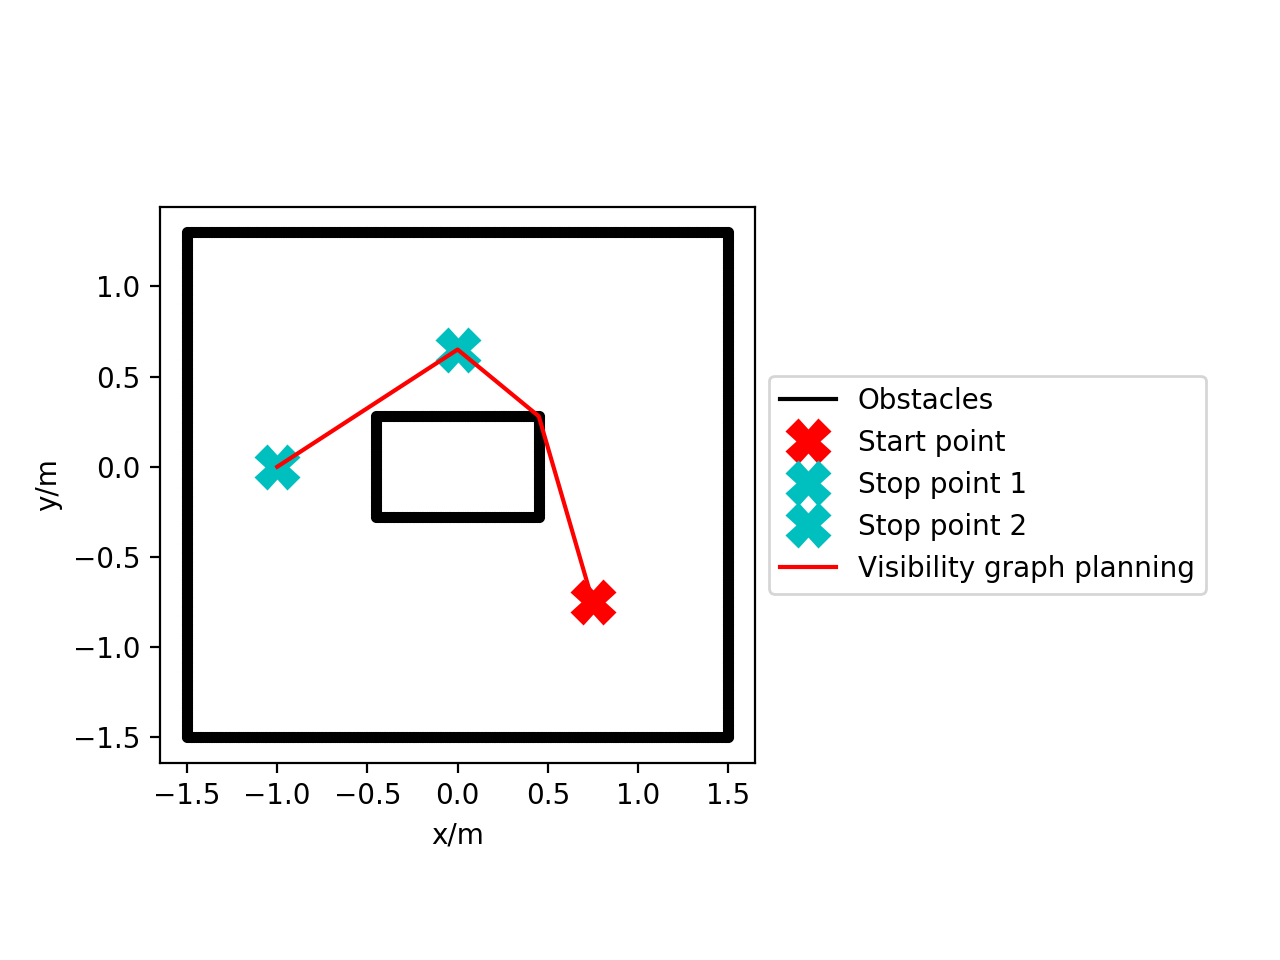

Text(0,0.5,u'y/m')

In [6]:
fig = plt.figure()
ax = plt.subplot(111)
# vo=plot_path(ax,overall_edges,'b')



    
ax.plot(ox, oy, ".k")
bo=ax.plot(ox[0], oy[0], "k")
st=ax.plot(waypoints[0][0],waypoints[0][1], "Xr",markersize=15)
d1t=ax.plot(waypoints[1][0],waypoints[1][1], "Xc",markersize=15)
d2t=ax.plot(waypoints[2][0],waypoints[2][1], "Xc",markersize=15)




 
pt=ax.plot(overall_path[:,0], overall_path[:,1],'r')
ax.set_aspect('equal')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])
ax.legend((bo[0],st[0],d1t[0],d2t[0],pt[0]),('Obstacles','Start point','Stop point 1','Stop point 2','Visibility graph planning'),loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('x/m')
plt.ylabel('y/m')

In [7]:
plt.savefig('./figures/visibility_graph_planning.eps', format='eps', dpi=1000)


In [79]:
fw.turn(initial_angle_fw)


ctl_constant_turning(70,initial_angle_fw-30,0.45,1)
for i in range (3):
    ctl_straight(70,1,1)


ctl_constant_turning(70,initial_angle_fw-30,1,1)
ctl_straight(70,1,1)
ctl_straight(70,1,1)

ctl_constant_turning(70,initial_angle_fw-30,1.1,1)
ctl_straight(70,1,1)
ctl_straight(70,1,1)
ctl_straight(70,0.5,1)